# Thyroid Nodule Ultrasound Analysis & TI-RADS Classification Using CNN and Transfer Learning Architectures

This project focuses on analyzing thyroid nodule ultrasound images and predicting their **TI-RADS (Thyroid Imaging Reporting and Data System) scores**.

I was personally motivated to work on this project because I have experienced **acute hyperthyroidism**, and my mother currently suffers from **hypothyroidism**. Seeing the impact thyroid disorders can have on everyday life inspired me to explore how deep learning can assist in **early detection and risk stratification** of thyroid nodules.

Thyroid nodules are common, and ultrasound imaging is the primary tool for assessing potential risk.
TI-RADS scoring helps clinicians decide whether a nodule requires a follow-up or further medical and coslty intervention like a biopsy.

Automating TI-RADS classification using deep learning can:
- Standardize readings across different clinicians
- Speed up diagnosis
- Assist radiologists in decision-making

The dataset comes from the Columbia thyroid ultrasound collection and includes:
- 400 patients and their thyroid nodules ultrasound images
- Annotation files (XML) with nodule regions marked via SVG polygons
- Metadata for each image including patient age and sex, composition, echogenicity, margins, calcifications, and TI-RADS score

The main goals of this project are:
1. Parse and organize the dataset (images, XML annotations, metadata)
2. Visualize nodules and their annotations
3. Generate binary masks from SVG points for segmentation
4. Build a **multimodal deep learning model** using:
   - CNN for image features
   - Metadata features for improved prediction
5. Predict **multiclass TI-RADS scores** for nodules
6. Evaluate model performance with accuracy, F1 score, and confusion matrix



#1.0 Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET # to handle xml data
import json # to convert the scalable vector graphic (svg) points in the xml file
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2 # used to fill mask
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import classification_report, confusion_matrix
import random

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

#2.0 Import, Inspect and Clean Data

We'll create a base directory object where the entire files are located then we'll list all files and split them by their file extension and see how many xml and image files we're working with.


In [3]:
base_dir = "/content/thyroid-nodules"

all_files = os.listdir(base_dir)

xml_files = [os.path.join(base_dir, f) for f in all_files if f.lower().endswith(".xml")]
jpeg_files = [os.path.join(base_dir, f) for f in all_files if f.lower().endswith((".jpg", ".jpeg"))]

print(f"Found {len(xml_files)} XML files and {len(jpeg_files)} JPEG files.")

Found 390 XML files and 480 JPEG files.


In [4]:
xml_files[0]

'/content/thyroid-nodules/67.xml'

## 2.1 Check Sample XML File

In [5]:
example_xml = xml_files[0]
example_path = os.path.join(base_dir, example_xml)

tree = ET.parse(example_path)
root = tree.getroot()

# print XML as string for 500 strings for readability

xml_str = ET.tostring(root, encoding = 'unicode')
print("Example XML file content:\n")
print(xml_str[:500], "\n...")

Example XML file content:

<case><number>67</number><age>59</age><sex>F</sex><composition>solid</composition><echogenicity>marked hypoechogenicity</echogenicity><margins>well defined</margins><calcifications>non</calcifications><tirads>4b</tirads><reportbacaf /><reporteco /><mark><image>1</image><svg>[{"points": [{"x": 291, "y": 127}, {"x": 282, "y": 127}, {"x": 272, "y": 131}, {"x": 264, "y": 136}, {"x": 259, "y": 139}, {"x": 249, "y": 143}, {"x": 243, "y": 146}, {"x": 241, "y": 152}, {"x": 240, "y": 157}, {"x": 240, "y" 
...


## 2.2 Prepare Metadata Structures by Creating a Dictionary for the Metadata and the SVG Points

In [6]:
metadata_data = {
    "Number": [],
    "Age": [],
    "Sex": [],
    "Composition": [],
    "Echogenicity": [],
    "Margins": [],
    "Calcifications": [],
    "Tirads": [],
    "Reportbacaf": [],
    "Reporteco": [],
}

svg_polygons = {}  # key: "{case_number}_{image_index}" -> list of polygons

In [7]:
invalid_images = set()

for xml_path in xml_files:
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # metadata elements

    def get_text(tag):
        node = root.find(tag)
        return node.text if node is not None else None

    case_number = get_text("number")
    metadata_data["Number"].append(int(case_number) if case_number else None)

    age_text = get_text("age")
    metadata_data["Age"].append(int(age_text) if age_text else None)

    for tag in ["Sex", "Composition", "Echogenicity", "Margins", "Calcifications", "Tirads", "Reportbacaf", "Reporteco"]:
        metadata_data[tag].append(get_text(tag.lower()))

    # mark nodes containing the image number and associated svg points

    for mark in root.findall("mark"):
        image_idx_node = mark.find("image")
        svg_node = mark.find("svg")

        # check if the mark tags are in the xml file, if not skip this xml
        if image_idx_node is None or svg_node is None:
            continue

        image_idx = image_idx_node.text
        svg_text = svg_node.text

        # if there is those mark tags, check if svg_text is empty or missing, if not skip this xml
        if not svg_text or not svg_text.strip():
            continue

        try:
        # try to parse JSON, if error happens then...
          polygons = json.loads(svg_text)
          svg_polygons[f"{case_number}_{image_idx}"] = polygons

        # handle the error
        except json.JSONDecodeError:
          snippet = svg_text[-50:]  # last 50 chars for debugging
          invalid_images.add(f"{case_number}_{image_idx}") # blacklist
          print(f"⚠️ Skipping invalid JSON in case {case_number}, image {image_idx}")
          print(f"Snippet: {snippet}")

⚠️ Skipping invalid JSON in case 197, image 1
Snippet:  {"x": 383, "y": 45}], "annotation": {}, "regionTy
⚠️ Skipping invalid JSON in case 203, image 1
Snippet: {"x": 215, "y": 154}, {"x": 215, "y": 161}, {"x": 
⚠️ Skipping invalid JSON in case 127, image 1
Snippet: ": 173, "y": 87}, {"x": 168, "y": 89}, {"x": 162, 
⚠️ Skipping invalid JSON in case 166, image 1
Snippet: 2, "y": 75}, {"x": 470, "y": 74}, {"x": 470, "y": 
⚠️ Skipping invalid JSON in case 54, image 1
Snippet:  "y": 144}, {"x": 373, "y": 137}, {"x": 373, "y": 
⚠️ Skipping invalid JSON in case 176, image 1
Snippet: }, {"x": 491, "y": 167}, {"x": 495, "y": 161}, {"x
⚠️ Skipping invalid JSON in case 205, image 1
Snippet: , {"x": 435, "y": 66}], "annotation": {}, "regionT
⚠️ Skipping invalid JSON in case 165, image 1
Snippet: {"x": 507, "y": 113}, {"x": 507, "y": 92}, {"x": 5


Since these amount of errors from trying to parse the json strings into python objects is small we will not use these images in our training, validation, and test sets. They'll be stored in the invalid_images blacklist.

##2.3 Create dataframe for metadata

In [8]:
metadata_df = pd.DataFrame(metadata_data)
metadata_df.sort_values(by = "Number", inplace = True)
metadata_df.set_index("Number", inplace = True)

In [9]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 1 to 400
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             304 non-null    float64
 1   Sex             305 non-null    object 
 2   Composition     200 non-null    object 
 3   Echogenicity    200 non-null    object 
 4   Margins         297 non-null    object 
 5   Calcifications  299 non-null    object 
 6   Tirads          298 non-null    object 
 7   Reportbacaf     0 non-null      object 
 8   Reporteco       21 non-null     object 
dtypes: float64(1), object(8)
memory usage: 30.5+ KB


In [10]:
metadata_df.isnull().sum()

,0
Age,86
Sex,85
Composition,190
Echogenicity,190
Margins,93
Calcifications,91
Tirads,92
Reportbacaf,390
Reporteco,369


In [11]:
metadata_df

,Age,Sex,Composition,Echogenicity,Margins,Calcifications,Tirads,Reportbacaf,Reporteco
Number,,,,,,,,,
1,NaN,None,None,None,None,None,None,None,None
2,49.0,F,solid,hyperechogenicity,well defined,non,2,None,None
3,31.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
4,37.0,F,spongiform,isoechogenicity,well defined,microcalcifications,4a,None,None
5,47.0,F,solid,hypoechogenicity,ill defined,microcalcifications,5,None,None
...,...,...,...,...,...,...,...,...,...
396,NaN,None,None,None,None,None,None,None,None
397,39.0,F,None,None,well defined smooth,non,2,None,THYROIDITIS
398,70.0,F,None,None,spiculated,non,4b,None,None


In [12]:
metadata_df[metadata_df["Age"].isnull()]

,Age,Sex,Composition,Echogenicity,Margins,Calcifications,Tirads,Reportbacaf,Reporteco
Number,,,,,,,,,
1,NaN,None,None,None,None,None,None,None,None
58,NaN,None,None,None,None,None,None,None,None
60,NaN,None,None,None,None,None,None,None,None
62,NaN,None,None,None,None,None,None,None,None
63,NaN,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
332,NaN,None,None,None,None,None,None,None,None
349,NaN,None,None,None,None,None,None,None,None
388,NaN,None,None,None,None,None,None,None,None


In [13]:
# count what each column contains and what each variable is (doesn't count NaN or None)

for col in metadata_df.columns:
    print(f"\nColumn: {col}")
    print(metadata_df[col].value_counts())


Column: Age
Age
47.0    11
50.0    11
56.0    10
63.0     9
55.0     9
        ..
14.0     1
19.0     1
25.0     1
86.0     1
71.0     1
Name: count, Length: 65, dtype: int64

Column: Sex
Sex
F    258
M     32
u     15
Name: count, dtype: int64

Column: Composition
Composition
solid                   117
predominantly solid      30
spongiform               28
predominantly cystic     13
dense                    10
cystic                    2
Name: count, dtype: int64

Column: Echogenicity
Echogenicity
isoechogenicity            84
hypoechogenicity           61
hyperechogenicity          39
marked hypoechogenicity    16
Name: count, dtype: int64

Column: Margins
Margins
well defined           145
well defined smooth     69
ill defined             24
microlobulated          19
spiculated              18
ill- defined            16
macrolobulated           6
Name: count, dtype: int64

Column: Calcifications
Calcifications
microcalcifications    121
non                     92
microcalcific

We will drop the Age and Sex columns because they contain 86 and 85 null values, respectively. These rows also have missing values in other columns, affecting 21.5% of the dataset. Dropping the rows would remove too much data, so it is preferable to drop the columns instead. We will retain the TI-RADS column, as a missing value would indicate a normal image. The Reportbacaf and Reporteco columns will also be removed.

For the categorical features, we will apply one-hot encoding to Sex, Composition, Echogenicity, Margins (after correcting “ill defined”), and Calcifications (after combining “micro” and “macro” categories).

The target variable for modeling will be TI-RADS.

TI-RADS shows scores of 2, 3, 4a, 4b, 4c and 5 while 92 rows are missing. I'm assuming those rows are having no score meaning because they are benign, a non malignant non canerous thyroid nodule. For this, I'll assign them with 1.


In [14]:
# create a new column for margins where "ill- defined" becomes "ill defined"

metadata_df["Margins_new"] = metadata_df["Margins"].replace({"ill- defined": "ill defined"})

In [15]:
# create a new column for calcifications combining the micros and macros and renaming non to none

metadata_df["Calcifications_new"] = metadata_df["Calcifications"].replace({
    "microcalcification": "microcalcifications",
    "macrocalcification": "macrocalcifications",
    "non": "none"
})

Copy metadata_df to new cleaned dataframe with one-hot encoded sex, echogenecity, composition, margins_new, calcifications_new columns

In [16]:
metadata_df_clean = metadata_df.copy()
metadata_df_clean = pd.get_dummies(
    metadata_df_clean,
    columns = ["Echogenicity", "Composition", "Margins_new", "Calcifications_new"],
    drop_first = False
)

In [17]:
metadata_df_clean.drop(columns = ["Age", "Sex", "Margins", "Calcifications", "Reportbacaf", "Reporteco"], inplace = True)

In [18]:
metadata_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 1 to 400
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Tirads                                  298 non-null    object
 1   Echogenicity_hyperechogenicity          390 non-null    bool  
 2   Echogenicity_hypoechogenicity           390 non-null    bool  
 3   Echogenicity_isoechogenicity            390 non-null    bool  
 4   Echogenicity_marked hypoechogenicity    390 non-null    bool  
 5   Composition_cystic                      390 non-null    bool  
 6   Composition_dense                       390 non-null    bool  
 7   Composition_predominantly cystic        390 non-null    bool  
 8   Composition_predominantly solid         390 non-null    bool  
 9   Composition_solid                       390 non-null    bool  
 10  Composition_spongiform                  390 non-null    bool  
 11  Margins_new

In [19]:
metadata_df_clean.isnull().sum()

,0
Tirads,92
Echogenicity_hyperechogenicity,0
Echogenicity_hypoechogenicity,0
Echogenicity_isoechogenicity,0
Echogenicity_marked hypoechogenicity,0
Composition_cystic,0
Composition_dense,0
Composition_predominantly cystic,0
Composition_predominantly solid,0
Composition_solid,0


In [20]:
# fill None in tirads column with 1

metadata_df_clean['Tirads'] = metadata_df_clean['Tirads'].fillna("1")

In [21]:
metadata_df_clean.head(5)

,Tirads,Echogenicity_hyperechogenicity,Echogenicity_hypoechogenicity,Echogenicity_isoechogenicity,Echogenicity_marked hypoechogenicity,Composition_cystic,Composition_dense,Composition_predominantly cystic,Composition_predominantly solid,Composition_solid,Composition_spongiform,Margins_new_ill defined,Margins_new_macrolobulated,Margins_new_microlobulated,Margins_new_spiculated,Margins_new_well defined,Margins_new_well defined smooth,Calcifications_new_macrocalcifications,Calcifications_new_microcalcifications,Calcifications_new_none
Number,,,,,,,,,,,,,,,,,,,,
1,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
3,4a,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False
4,4a,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False
5,5,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False


In [22]:
metadata_df_clean.tail(10)

,Tirads,Echogenicity_hyperechogenicity,Echogenicity_hypoechogenicity,Echogenicity_isoechogenicity,Echogenicity_marked hypoechogenicity,Composition_cystic,Composition_dense,Composition_predominantly cystic,Composition_predominantly solid,Composition_solid,Composition_spongiform,Margins_new_ill defined,Margins_new_macrolobulated,Margins_new_microlobulated,Margins_new_spiculated,Margins_new_well defined,Margins_new_well defined smooth,Calcifications_new_macrocalcifications,Calcifications_new_microcalcifications,Calcifications_new_none
Number,,,,,,,,,,,,,,,,,,,,
390,4c,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
391,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
392,4c,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
394,5,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
395,4a,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
396,1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
397,2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
398,4b,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
399,4b,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False


In [23]:
# convert only boolean columns to 1 and 0

# select only the boolean columns (the dummies)
bool_cols = metadata_df_clean.select_dtypes(include="bool").columns

# convert just those columns to integers
metadata_df_clean[bool_cols] = metadata_df_clean[bool_cols].astype(int)

In [24]:
metadata_df_clean.head(5)

,Tirads,Echogenicity_hyperechogenicity,Echogenicity_hypoechogenicity,Echogenicity_isoechogenicity,Echogenicity_marked hypoechogenicity,Composition_cystic,Composition_dense,Composition_predominantly cystic,Composition_predominantly solid,Composition_solid,Composition_spongiform,Margins_new_ill defined,Margins_new_macrolobulated,Margins_new_microlobulated,Margins_new_spiculated,Margins_new_well defined,Margins_new_well defined smooth,Calcifications_new_macrocalcifications,Calcifications_new_microcalcifications,Calcifications_new_none
Number,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1
3,4a,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,4a,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


In [25]:
print("\nExample SVG key and polygons:")
key = list(svg_polygons.keys())[0]
print("Key:", key)
print("Type:", type(svg_polygons[key]))
print("Full SVG string:\n", svg_polygons[key][:1000])


Example SVG key and polygons:
Key: 67_1
Type: <class 'list'>
Full SVG string:
 [{'points': [{'x': 291, 'y': 127}, {'x': 282, 'y': 127}, {'x': 272, 'y': 131}, {'x': 264, 'y': 136}, {'x': 259, 'y': 139}, {'x': 249, 'y': 143}, {'x': 243, 'y': 146}, {'x': 241, 'y': 152}, {'x': 240, 'y': 157}, {'x': 240, 'y': 158}, {'x': 240, 'y': 168}, {'x': 240, 'y': 174}, {'x': 240, 'y': 176}, {'x': 253, 'y': 196}, {'x': 256, 'y': 198}, {'x': 260, 'y': 199}, {'x': 268, 'y': 203}, {'x': 271, 'y': 203}, {'x': 281, 'y': 205}, {'x': 294, 'y': 210}, {'x': 299, 'y': 212}, {'x': 306, 'y': 212}, {'x': 317, 'y': 212}, {'x': 326, 'y': 211}, {'x': 333, 'y': 209}, {'x': 343, 'y': 204}, {'x': 344, 'y': 203}, {'x': 351, 'y': 191}, {'x': 351, 'y': 191}, {'x': 353, 'y': 178}, {'x': 353, 'y': 174}, {'x': 347, 'y': 163}, {'x': 344, 'y': 161}, {'x': 341, 'y': 158}, {'x': 340, 'y': 151}, {'x': 339, 'y': 148}, {'x': 334, 'y': 140}, {'x': 332, 'y': 138}, {'x': 326, 'y': 135}, {'x': 313, 'y': 131}, {'x': 313, 'y': 131}, {'x':

## 2.4 Check and clean images

Next, we'll check the image dimensions. This step is important for a few reasons:

- Consistency for modeling: CNNs need all images to have the same height and width, so verifying dimensions helps ensure everything is ready for resizing or batching.

- SVG coordinate alignment: The SVG points are mapped in pixel coordinates relative to each image. Knowing the exact size is necessary to generate masks correctly to overlay the ultrasound image.

- Catching corrupted or odd files: Sometimes an image might have an unexpected shape, number of channels, or file format, so this step helps spot and fix those issues early.

In [26]:
dimensions = []

for img_path in jpeg_files:
    with Image.open(img_path) as img:
        width, height = img.size
        dimensions.append((img_path, width, height))

# Print a few examples
for i, (path, w, h) in enumerate(dimensions[:5]):
    print(f"{i+1}: {path} -> {w}x{h}")

# Check unique dimensions
unique_sizes = set((w, h) for _, w, h in dimensions)
print("\nUnique image sizes:", unique_sizes)


1: /content/thyroid-nodules/398_1.jpg -> 560x360
2: /content/thyroid-nodules/198_1.jpg -> 560x360
3: /content/thyroid-nodules/85_2.jpg -> 560x360
4: /content/thyroid-nodules/370_1.jpg -> 560x360
5: /content/thyroid-nodules/81_2.jpg -> 560x360

Unique image sizes: {(560, 360)}


Since ultrasound images have dimensions 560x360, we need them to be squares or 224x224 to work with CNN architectures. We'll resize the images but keep the proportions and add padding around the images to reach the target size.

In [27]:
# path of images

img_dir = base_dir  # JPEGs are directly under base_dir
TARGET_SIZE = (224, 224)  # CNN input size (width, height)

We'll create functions to scale the images and create a black and white mask to bifurcate the thyroid nodules in the images (white being the segment of interest)

In [28]:
def scale_points(points, orig_size, target_size):
    """Scale SVG points to match resized image size"""
    orig_w, orig_h = orig_size
    target_w, target_h = target_size
    scale_x = target_w / orig_w
    scale_y = target_h / orig_h
    return [{"x": int(p["x"] * scale_x), "y": int(p["y"] * scale_y)} for p in points]

In [29]:
def scale_points(points, orig_size, target_size):
    """Scale SVG points to match resized image size"""
    orig_w, orig_h = orig_size
    target_w, target_h = target_size

    # Compute scale while keeping aspect ratio
    scale = min(target_w / orig_w, target_h / orig_h)

    # Compute padding added to center the image
    pad_w = (target_w - orig_w * scale) / 2
    pad_h = (target_h - orig_h * scale) / 2

    # Scale and shift points
    scaled = []
    for pt in points:
        x = pt["x"] * scale + pad_w
        y = pt["y"] * scale + pad_h
        scaled.append({"x": x, "y": y})
    return scaled

In [30]:
def polygon_to_mask(points, target_size):
    """Convert polygon points to binary mask"""
    mask = np.zeros(target_size[::-1], dtype = np.uint8)  # target_size[::-1] = height, width
    pts = np.array([[p["x"], p["y"]] for p in points], np.int32)
    pts = pts.reshape((-1, 1, 2)) #-1: automatically infer dimension needed, 2: num. of dimension (xy = 2)
    cv2.fillPoly(mask, [pts], color = 1)
    return mask

### 2.4.1 Process Images and Masks

Process images and masks

For each image in the jpeg files, we'll extract the filename and generate a unique ID for the image (like 99_1), open the image and records its original size, resize the image for the CNN with padding to the target dimensions. The resized image is stored in a list along with its unique image ID (img_id).

Then generate binary masks for nodules (if available). Check if there are SVG polygons for this image in svg_polygons. Each polygon outlines a nodule in the original image. The polygon points are scaled to match the resized image using our custom scaling function. A binary mask is created from each polygon, where pixels inside the nodule = 1 (white) and outside = 0 (black). If there are multiple polygons in one image, they are combined into a single mask. The final mask is stored in masks_dict using the image ID as the key.

So we'll have a list of the resized image with it's unique image id and a dictionary of the resized image's binary map with it's unique image id.

In [31]:
processed_images = []  # store (filename, PIL.Image)
masks_dict = {}        # key = "{case_number}_{image_index}", value = mask


In [32]:
for img_path in jpeg_files:
    filename = os.path.basename(img_path)
    img_id = os.path.splitext(filename)[0]  # [0] bc filename 99_1.jpg splittext gives (root, ext)
    img = Image.open(img_path)
    orig_size = img.size  # (width, height)

    # Resize with padding
    img_resized = ImageOps.pad(img, TARGET_SIZE, color = (0,0,0))
    processed_images.append((img_id, img_resized))

    # Generate masks if SVG polygons exist

    if img_id in svg_polygons:
        masks = []
        for polygon_dict in svg_polygons[img_id]:
            points = polygon_dict["points"]  # get the points for this polygon
            scaled_pts = scale_points(points, orig_size, TARGET_SIZE)
            mask = polygon_to_mask(scaled_pts, TARGET_SIZE)
            masks.append(mask)
        if masks:
            final_mask = np.clip(np.sum(masks, axis=0), 0, 1)  # combine multiple masks
            masks_dict[img_id] = final_mask

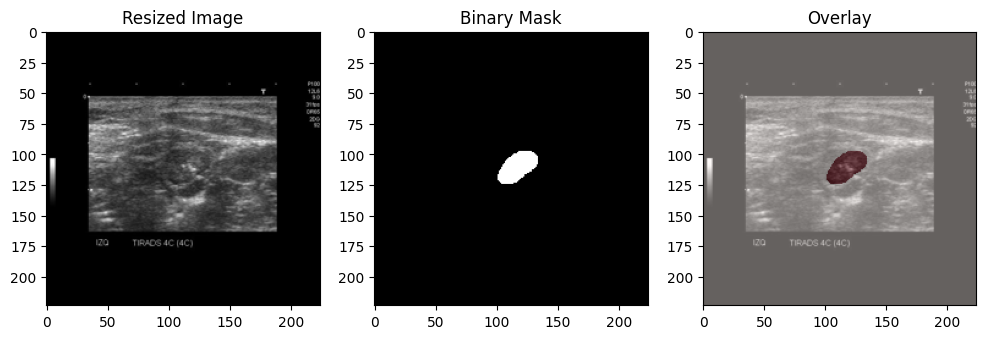

In [33]:
# Example visualization
plt.figure(figsize = (12, 5))

plt.subplot(1,3,1)
plt.imshow(img_resized, cmap = 'gray')
plt.title("Resized Image")

plt.subplot(1,3,2)
plt.imshow(mask, cmap = 'gray')
plt.title("Binary Mask")

plt.subplot(1,3,3)
plt.imshow(img_resized, cmap = 'gray')
plt.imshow(mask, cmap = 'Reds', alpha = 0.4)
plt.title("Overlay")
plt.show()


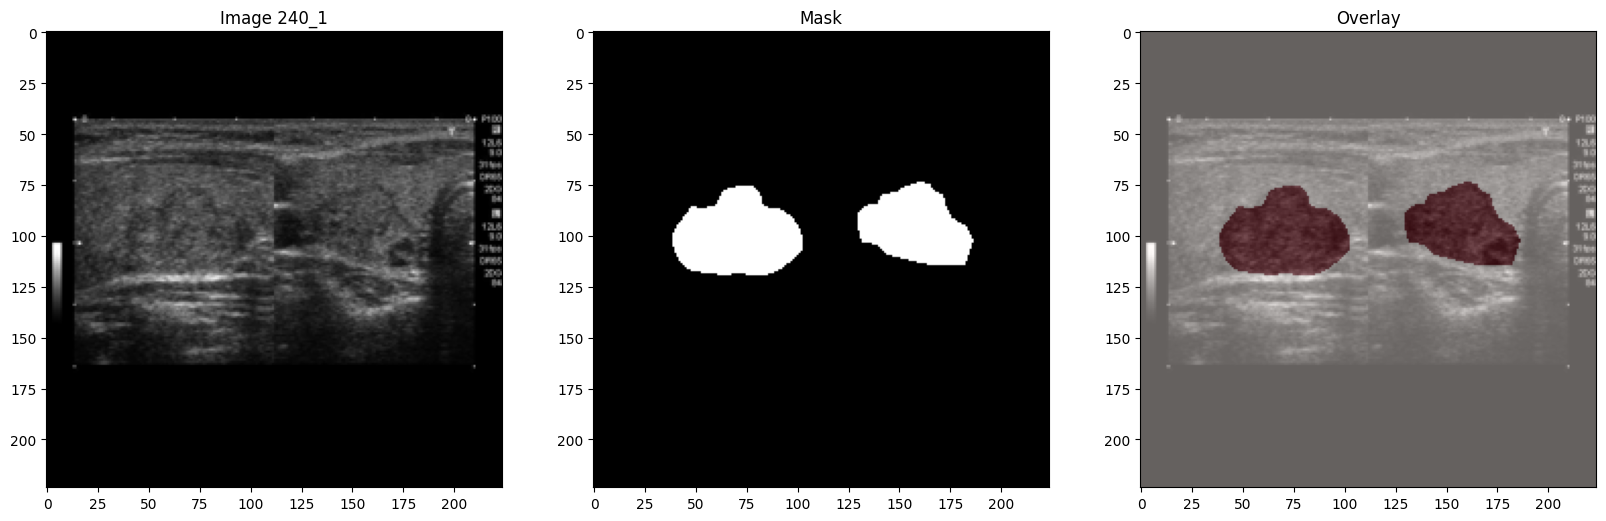

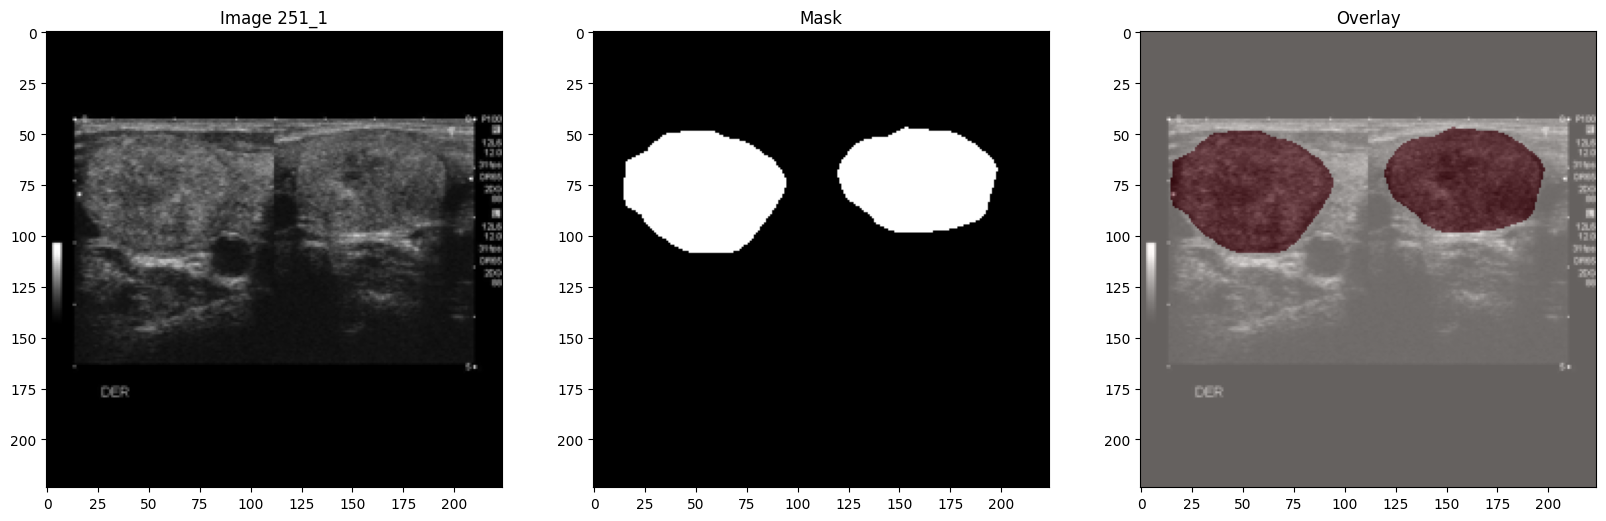

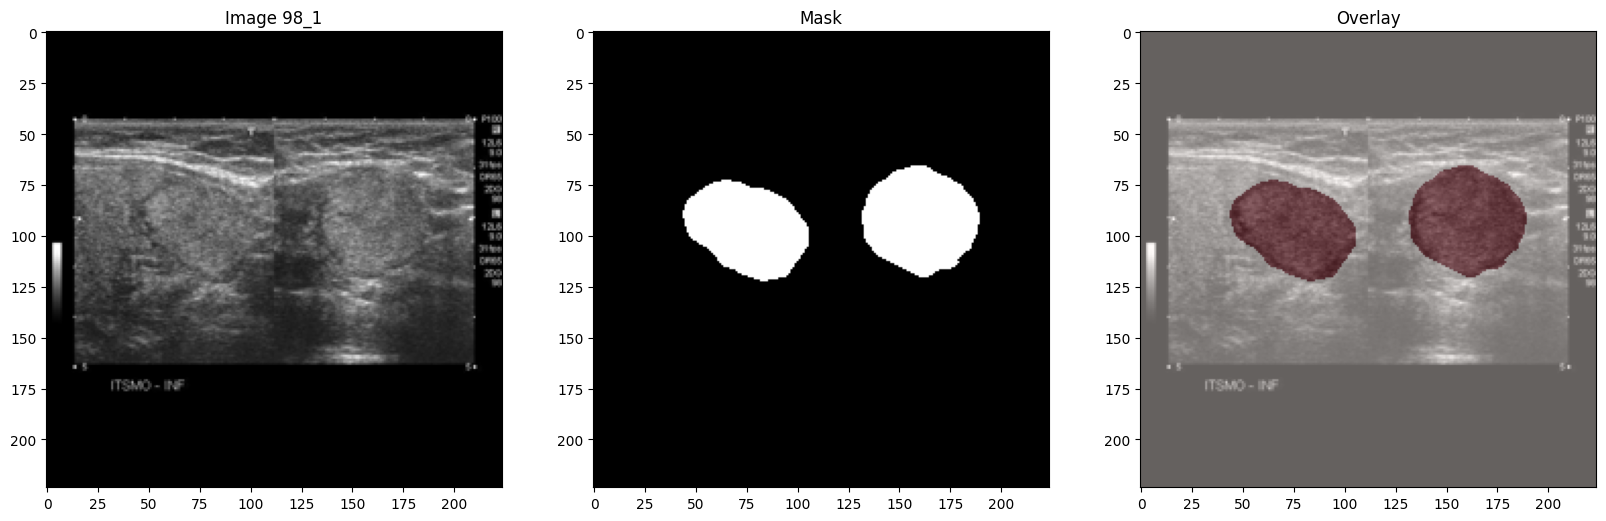

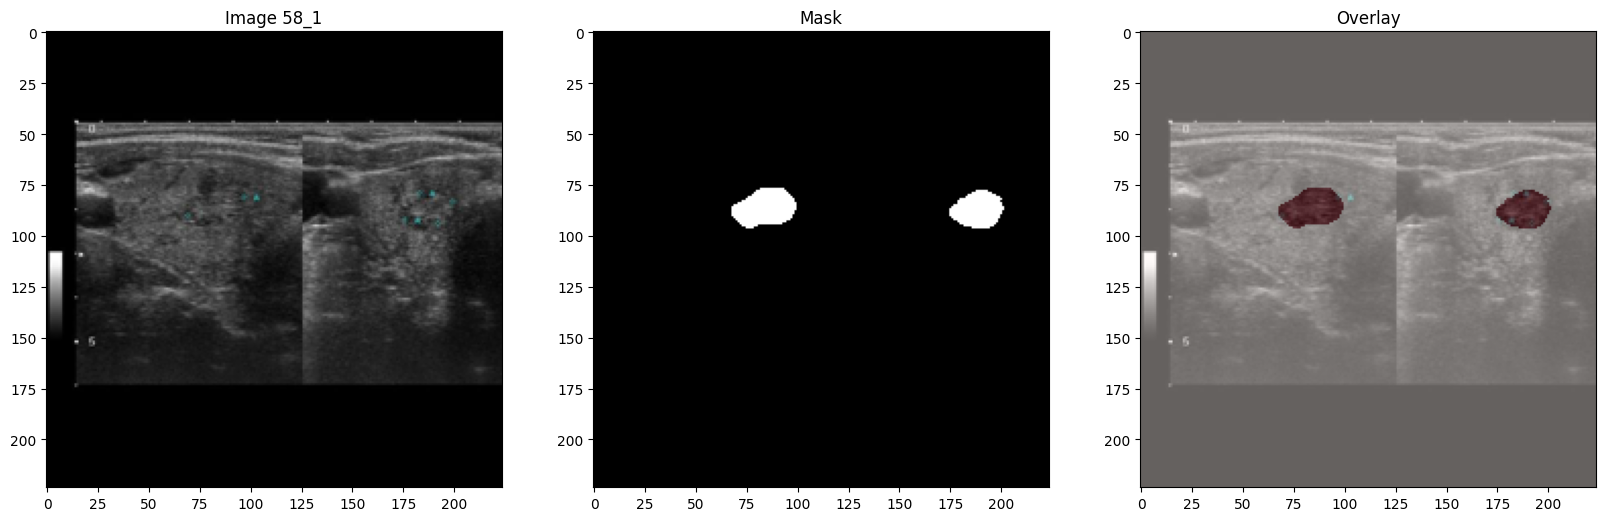

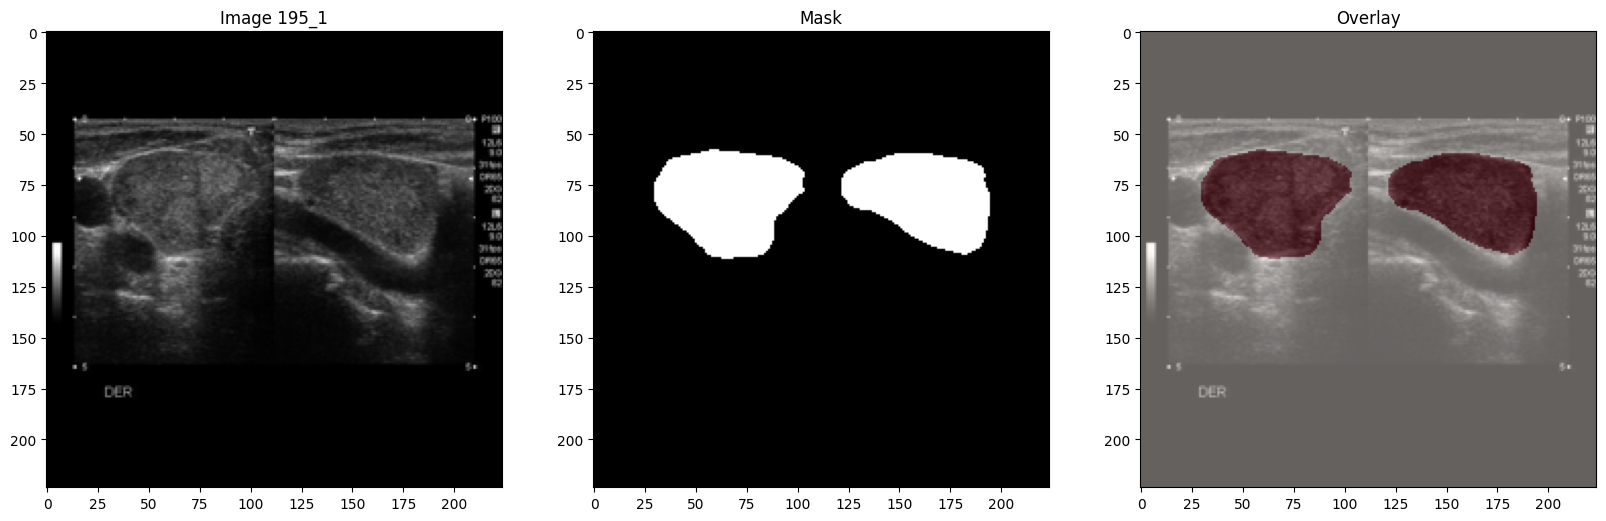

In [34]:
# Check 5 random examples
examples = random.sample(processed_images, 5)

for img_id, img in examples:
    mask = masks_dict.get(img_id)

    plt.figure(figsize = (20, 8))

    # resized image
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = 'gray')
    plt.title(f"Image {img_id}")

    # mask
    plt.subplot(1,3,2)
    if mask is not None:
        plt.imshow(mask, cmap = 'gray')
    plt.title("Mask")

    # overlay
    plt.subplot(1,3,3)
    plt.imshow(img, cmap = 'gray')
    if mask is not None:
        plt.imshow(mask, cmap = 'Reds', alpha = 0.4)
    plt.title("Overlay")

    plt.show()

#3.0 Prepare the Data for Modeling

Next, we need to align images with their metadata and labels, but the images are named with their case number and their image number and the metadata just has their case number. So we need to merge. these two with a primary key with something like their case number.

First, we'll create a new dataframe containing all our processed images, with columns image_id and their case number. We'll merge this new dataframe with the metadata and perform a left merge on the number column where the left dataframe is the new dataframe and the right dataframe is the metadata table.

In [35]:
# new image dataframe
image_df = pd.DataFrame({
    "image_id": [img_id for img_id, _ in processed_images]
    })
image_df["Number"] = image_df["image_id"].str.split("_").str[0].astype(int)

# left merge
metadata_df_expanded = image_df.merge(metadata_df_clean, on = "Number", how = "left")


In [36]:
# Check metadata
print('---Metadata Columns---\n')
print(metadata_df_expanded.columns)
print('\n ---Metadata Sample of Image Id and TIRADS--- \n')
print(metadata_df_expanded[['image_id', 'Tirads']].head())
print('\n ---Metadata Column Count--- \n')\
# count number of columns or features in metadata
print(metadata_df_expanded.shape[1])

# Check one processed image
print('\n---One Processed Image---\n')
print(processed_images[0][0])  # should match an image_id in metadata_df

# Check one mask
print('\n---One Mask Dimension---\n')
first_key = list(masks_dict.keys())[0]
print(first_key, masks_dict[first_key].shape)

---Metadata Columns---

Index(['image_id', 'Number', 'Tirads', 'Echogenicity_hyperechogenicity',
       'Echogenicity_hypoechogenicity', 'Echogenicity_isoechogenicity',
       'Echogenicity_marked hypoechogenicity', 'Composition_cystic',
       'Composition_dense', 'Composition_predominantly cystic',
       'Composition_predominantly solid', 'Composition_solid',
       'Composition_spongiform', 'Margins_new_ill defined',
       'Margins_new_macrolobulated', 'Margins_new_microlobulated',
       'Margins_new_spiculated', 'Margins_new_well defined',
       'Margins_new_well defined smooth',
       'Calcifications_new_macrocalcifications',
       'Calcifications_new_microcalcifications', 'Calcifications_new_none'],
      dtype='object')

 ---Metadata Sample of Image Id and TIRADS--- 

  image_id Tirads
0    398_1     4b
1    198_1     4a
2     85_2      5
3    370_1     4c
4     81_2      5

 ---Metadata Column Count--- 

22

---One Processed Image---

398_1

---One Mask Dimension---

398_

In [37]:
metadata_df_expanded['Tirads'].value_counts()

,count
Tirads,
1,131
4a,96
4b,79
4c,68
5,45
2,42
3,19


Because there's an imbalance in scores, if we trained with this data, the model will probably learn to predict TI-RADS score 1 most of the time because that's the dominant class and will thus have poorer recall on higher TI-RADS scores where classification significantly matters more. As a result of this class imbalance, we will use class weights to make it more balanced. We will apply the weights after we split the data into training and testing sets.

Next, we need to prepare the data for our multimodal CNN architecture. We'll create a function to handle this by taking the aligned images, masks, and metadata and convert them into arrays that the model can use. It will resize and normalize images, ensures the masks are shaped correctly, converts the metadata into numerical features dropping identifiers and target labels and maps the TI-RADS scores into numerical labels. These arrays will align so each row of each array coreresponds to the same example. The function will return an images, masks, metadata and labels array which will be fed into the model for training.

In [38]:
# create a fct to prepare dataset with resized images, masks, metadata to ensure they all match

def prepare_dataset(processed_images, masks_dict, metadata_expanded, invalid_images = set(), target_size = (224,224)):
    """
    Prepare arrays for multimodal CNN: images, masks, metadata, and labels.

    Arguments:
    - processed_images: list of tuples (img_id, PIL.Image)
    - masks_dict: dict {img_id: mask_array}
    - metadata_df: pandas DataFrame with encoded metadata and 'image_id' column
    - invalid_images: set of img_ids to exclude
    - target_size: desired image/mask size (width, height)

    Returns:
    - X_img, X_mask, X_meta, y arrays
    """

    # Filter out invalid images
    valid_images = [(img_id, img) for img_id, img in processed_images if img_id not in invalid_images]
    valid_masks_dict = {img_id: mask for img_id, mask in masks_dict.items() if img_id not in invalid_images}
    valid_metadata = metadata_expanded[~metadata_expanded['image_id'].isin(invalid_images)].reset_index(drop = True)

    # Create image array
    images_array = np.array([np.array(img.resize(target_size)) for img_id, img in valid_images], dtype = np.float32) / 255.0

    # Create mask array
    masks_list = []
    for img_id, _ in valid_images:
        mask = valid_masks_dict.get(img_id, np.zeros(target_size, dtype = np.uint8))
        masks_list.append(mask)
    masks_array = np.expand_dims(np.array(masks_list), axis = -1)

    # Create metadata array
    metadata_array = valid_metadata.drop(columns = ['image_id', 'Tirads']).to_numpy().astype(np.float32)

    # Create label array
    tirads_map = {'1':0, '2':1, '3':2, '4a':3, '4b':4, '4c':5, '5':6}
    labels_array = valid_metadata['Tirads'].map(tirads_map).to_numpy()

    return images_array, masks_array, metadata_array, labels_array

In [39]:
# Prepare dataset
X_img, X_mask, X_meta, y = prepare_dataset(processed_images, masks_dict, metadata_df_expanded, invalid_images, target_size = (224, 224))

In [40]:
print("---X_img Shape---\n", X_img.shape)
print("\n---X_mask Shape---\n", X_mask.shape)
print("\n---X_meta Shape---\n", X_meta.shape)
print("\n---y Shape---\n",  y.shape)

---X_img Shape---
 (472, 224, 224, 3)

---X_mask Shape---
 (472, 224, 224, 1)

---X_meta Shape---
 (472, 20)

---y Shape---
 (472,)


In [41]:
# Train test split
X_img_train, X_img_test, X_mask_train, X_mask_test, X_meta_train, X_meta_test, y_train, y_test = train_test_split(
    X_img, X_mask, X_meta, y, test_size = 0.2, stratify = y, shuffle = True, random_state = 42)

print("Train shapes:", X_img_train.shape, X_mask_train.shape, X_meta_train.shape, y_train.shape)
print("Test shapes:", X_img_test.shape, X_mask_test.shape, X_meta_test.shape, y_test.shape)

Train shapes: (377, 224, 224, 3) (377, 224, 224, 1) (377, 20) (377,)
Test shapes: (95, 224, 224, 3) (95, 224, 224, 1) (95, 20) (95,)


In [42]:
# Compute class weights from the training labels only
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = classes,
    y = y_train
)
class_weights = dict(zip(classes, class_weights))
print(class_weights)

{np.int64(0): np.float64(0.5178571428571429), np.int64(1): np.float64(1.632034632034632), np.int64(2): np.float64(3.5904761904761906), np.int64(3): np.float64(0.7277992277992278), np.int64(4): np.float64(0.882903981264637), np.int64(5): np.float64(0.9973544973544973), np.int64(6): np.float64(1.496031746031746)}


# 4.0 CNN Model Architecture

we're going to build a function to easily instantiate the model with different parameters.

The function will take the following parameters:
ultrasound images shape, mask shape, metadata dimensions, and number of categories to predict.

The images and masks will go through a basic cnn architecture first with a convulational layer with 32 filters and kernel size  in the first layer where features are extracted from the images, a maxpooling layer to reduce spatial dimension while keeping important features, a second convulational layer with 64 filters, and finally a global average pooling layer where features are flattened to connect layers and summarize the image.

The metadata will undergo a neural network with two layers, the first having 32 neurons and the second having 16.

The images, masks, and metadata will all be combined together into a neural network for our first model.

The model will then be compiled setting up the optimizer, the loss function to measure errors, and performance metrics.

Finally the model will be fitted with the training data.

## 4.1 Build the CNN Model Architecture

In [43]:
def build_multimodal_model(img_shape = (224, 224, 3), mask_shape = (224, 224, 1), meta_dim = 20, num_classes = 7):
    # Image branch
    img_input = Input(shape = img_shape, name = "image_input")
    x = layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(img_input)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Mask branch
    mask_input = Input(shape = mask_shape, name = "mask_input")
    m = layers.Conv2D(16, 3, activation = 'relu', padding = 'same')(mask_input)
    m = layers.MaxPooling2D(2)(m)
    m = layers.Conv2D(32, 3, activation = 'relu', padding = 'same')(m)
    m = layers.GlobalAveragePooling2D()(m)

    # Metadata branch
    meta_input = Input(shape = (meta_dim,), name = "meta_input")
    d = layers.Dense(32, activation = 'relu')(meta_input)
    d = layers.Dense(16, activation = 'relu')(d)

    # Combine branches
    combined = layers.Concatenate()([x, m, d])
    z = layers.Dense(64, activation = 'relu')(combined)
    z = layers.Dense(32, activation = 'relu')(z)
    output = layers.Dense(num_classes, activation = 'softmax')(z)

    model = models.Model(inputs = [img_input, mask_input, meta_input], outputs=output)
    return model


In [44]:
# Build and compile the model
model = build_multimodal_model()
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [45]:
# Print the model summary to inspect what the structure looks like
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │        160 │ mask_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        672 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ conv2d_3[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      7,232 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 7)         │        231 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,935 (136.46 KB)

 Trainable params: 34,935 (136.46 KB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Fit the Model with Training Data

In [46]:
# Create a function for early stopping to monitor if model is improving
early_stop = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

In [47]:
# Fit the model with training data
history = model.fit(
    [X_img_train, X_mask_train, X_meta_train],
    y_train,
    class_weight = class_weights,
    validation_split = 0.2,
    batch_size = 8,
    epochs = 30,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 871ms/step - accuracy: 0.1352 - loss: 4.1845 - val_accuracy: 0.0395 - val_loss: 2.1013
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 857ms/step - accuracy: 0.0500 - loss: 2.0867 - val_accuracy: 0.0395 - val_loss: 2.0329
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 855ms/step - accuracy: 0.0692 - loss: 2.0563 - val_accuracy: 0.0526 - val_loss: 2.0404
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 824ms/step - accuracy: 0.0853 - loss: 2.0522 - val_accuracy: 0.0526 - val_loss: 1.9932
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 835ms/step - accuracy: 0.1010 - loss: 2.0263 - val_accuracy: 0.1447 - val_loss: 1.9923
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 33s 870ms/step - accuracy: 0.1415 - loss: 2.0021 - val_accuracy: 0.0789 - val_loss: 1.9889
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 842ms/step - accuracy: 0.1694 - loss: 2.0820 - val_accuracy: 0.1974 - val_loss: 1.9305
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 825ms/step - accuracy: 0.1499 - loss: 1.9420 - val_accu

In [48]:
# Last epoch values
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])
print("Final training accuracy:", history.history['accuracy'][-1])
print("Final validation accuracy:", history.history['val_accuracy'][-1])

Final training loss: 1.0016809701919556
Final validation loss: 1.067322850227356
Final training accuracy: 0.6279069781303406
Final validation accuracy: 0.5789473652839661


In [49]:
# Best epoch with lowest validation loss (model will use those weights)
best_epoch_cnn = np.argmin(history.history['val_loss']) + 1 # since epoch 1 index 0
print(f"Best epoch (lowest val_loss): {best_epoch_cnn}")
print(f"Best val_loss: {min(history.history['val_loss']):.4f}")

Best epoch (lowest val_loss): 26
Best val_loss: 1.0440


This CNN model has a 62.46% training accuracy and a 60.53% validation accuracy.

## 4.3 Performance Metrics

### 4.3.1 CNN Training Loss and Accuracy

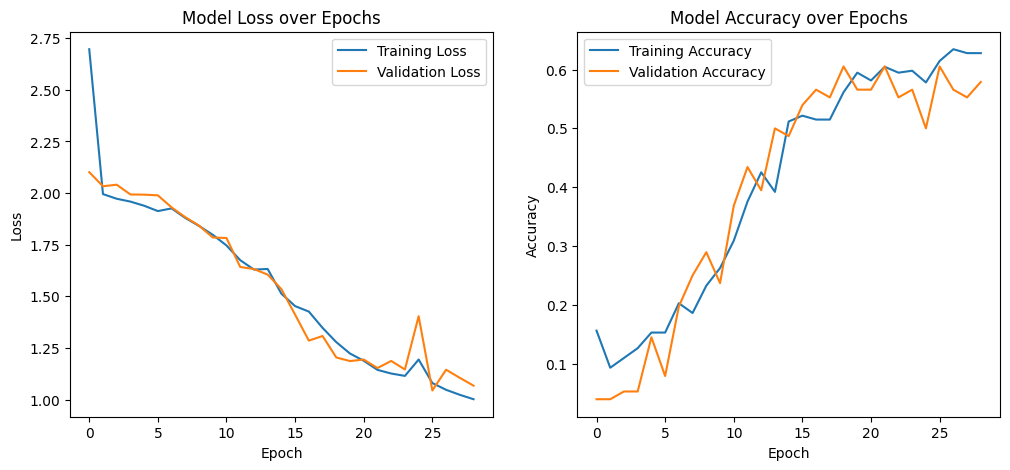

In [50]:
# Training loss and accuracy history
train_loss = history.history['loss']
train_acc = history.history['accuracy']

# Validation loss and accuracy history
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Loss curve
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4.3.2 CNN Test Classification Results

In [51]:
loss, acc = model.evaluate([X_img_test, X_mask_test, X_meta_test], y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6242 - loss: 0.9872


In [52]:
print(f"CNN Test Accuracy: {acc:.4f}")
print(f"CNN Test Loss: {loss:.4f}")

CNN Test Accuracy: 0.6000
CNN Test Loss: 1.0274


The CNN model had predicted 60% accuracy and a loss score of 1.03 on the test data.

In [53]:
y_pred = model.predict([X_img_test, X_mask_test, X_meta_test])
y_pred_classes = y_pred.argmax(axis = 1)

print(classification_report(y_test, y_pred_classes))
print(confusion_matrix(y_test, y_pred_classes))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        26
           1       0.50      0.62      0.56         8
           2       0.67      0.50      0.57         4
           3       0.46      0.32      0.38        19
           4       0.50      0.44      0.47        16
           5       0.35      0.69      0.46        13
           6       1.00      0.44      0.62         9

    accuracy                           0.60        95
   macro avg       0.63      0.56      0.57        95
weighted avg       0.65      0.60      0.60        95

[[24  0  0  0  0  2  0]
 [ 0  5  1  1  0  1  0]
 [ 0  1  2  1  0  0  0]
 [ 0  2  0  6  4  7  0]
 [ 1  2  0  4  7  2  0]
 [ 0  0  0  1  3  9  0]
 [ 0  0  0  0  0  5  4]]


#6.0 Transfer Learning

Given our CNN model's performance, we'll try to improve it by using transfer learning. In this method, we will use a pretrained model that has alrealdy learned rich feature representations from massive datasets like ImageNet, in this case DenseNet121, and use it on the images, while at the same time use a simple CNN architecture for the masks, and a dense layer for the metadata. For the transfer learning base model, we'll freeze the weights so it won't be

## 6.1 Build the Transfer Learning Model Architecture

In [54]:
def build_transfer_learning_model(
    img_shape = (224, 224, 3), mask_shape = (224, 224, 1), meta_dim = 20, num_classes = 7
):
  # Image branch removing the final classification layer (top = false) since we have different objectives and just want the extraction and no updating weights to base model
  img_input = Input(shape = img_shape, name = "image_input")
  base_model = DenseNet121(
      weights = "imagenet",
      include_top = False,
      input_tensor = img_input)
  base_model.trainable = False
  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(128, activation = 'relu')(x)
  x = layers.Dropout(0.3)(x)

  # Mask branch
  mask_input = Input(shape = mask_shape, name = "mask_input")
  m = layers.Conv2D(32, (3, 3), activation = 'relu')(mask_input)
  m = layers.MaxPooling2D()(m)
  m = layers.Conv2D(64, (3, 3), activation = 'relu')(m)
  m = layers.GlobalAveragePooling2D()(m)
  m = layers.Dense(64, activation = 'relu')(m)

  # Metadat branch
  meta_input = Input(shape = (meta_dim,), name = "meta_input")
  d = layers.Dense(32, activation = 'relu')(meta_input)
  d = layers.Dropout(0.3)(d)
  d = layers.Dense(16, activation = 'relu')(d)

  # Combine
  combined = layers.concatenate([x, m, d])
  z = layers.Dense(64, activation = 'relu')(combined)
  z = layers.Dropout(0.3)(z)
  output = layers.Dense(num_classes, activation = 'softmax')(z)

  model = models.Model(inputs = [img_input, mask_input, meta_input], outputs = output)
  return model


In [55]:
# Build and compile the model
tl_model = build_transfer_learning_model()
tl_model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [56]:
# Print the model summary to inspect what the structure looks like
tl_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,206,711 (27.49 MB)

 Trainable params: 169,207 (660.96 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 6.2 Fit the Model with Training Data

In [57]:
# Fit the model with training data
tl_history = tl_model.fit(
    [X_img_train, X_mask_train, X_meta_train],
    y_train,
    class_weight = class_weights,
    validation_split = 0.2,
    batch_size = 8,
    epochs = 30,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.0904 - loss: 14.8922 - val_accuracy: 0.1184 - val_loss: 4.1634
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1290 - loss: 6.6505 - val_accuracy: 0.0921 - val_loss: 2.4187
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.2006 - loss: 4.3265 - val_accuracy: 0.1974 - val_loss: 1.9585
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.1874 - loss: 2.9247 - val_accuracy: 0.1711 - val_loss: 1.9638
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1702 - loss: 2.5321 - val_accuracy: 0.1974 - val_loss: 1.9394
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.1819 - loss: 2.2526 - val_accuracy: 0.2105 - val_loss: 1.9431
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2057 - loss: 2.0997 - val_accuracy: 0.2105 - val_loss: 1.9432
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.1891 - loss: 2.0549 - val_accuracy: 0.0395 - val_loss

In [58]:
# Last epoch values
print("Final training loss:", tl_history.history['loss'][-1])
print("Final validation loss:", tl_history.history['val_loss'][-1])
print("Final training accuracy:", tl_history.history['accuracy'][-1])
print("Final validation accuracy:", tl_history.history['val_accuracy'][-1])

Final training loss: 1.979659914970398
Final validation loss: 1.9435662031173706
Final training accuracy: 0.17275747656822205
Final validation accuracy: 0.03947368264198303


In [59]:
# Best epoch with lowest validation loss (model will use those weights)
best_epoch_tl = np.argmin(tl_history.history['val_loss']) + 1
print(f"Best epoch (lowest val_loss): {best_epoch_tl}")
print(f"Best val_loss: {min(tl_history.history['val_loss']):.4f}")

Best epoch (lowest val_loss): 5
Best val_loss: 1.9394


This transfer learning model has a 17.02% training accuracy and a 19.74% validation accuracy.

## 6.3 Performance Metrics

### 6.3.1 Transfer Learning Training Loss and Accuracy

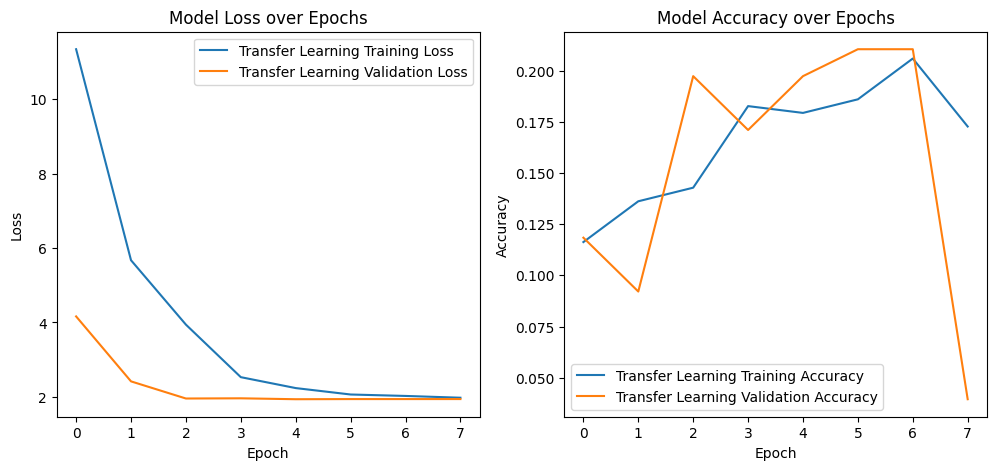

In [60]:
# Training loss and accuracy history
tl_train_loss = tl_history.history['loss']
tl_train_acc = tl_history.history['accuracy']

# Validation loss and accuracy history
tl_val_loss = tl_history.history['val_loss']
tl_val_acc = tl_history.history['val_accuracy']

# Loss curve
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(tl_train_loss, label = 'Transfer Learning Training Loss')
plt.plot(tl_val_loss, label = 'Transfer Learning Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(tl_train_acc, label = 'Transfer Learning Training Accuracy')
plt.plot(tl_val_acc, label = 'Transfer Learning Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 6.3.2 Transfer Learning Test Classification Results

In [61]:
tl_loss, tl_acc = tl_model.evaluate([X_img_test, X_mask_test, X_meta_test], y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step - accuracy: 0.1807 - loss: 1.9441


In [62]:
print(f"TL Test Accuracy: {tl_acc:.4f}")
print(f"TL Test Loss: {tl_loss:.4f}")

TL Test Accuracy: 0.1895
TL Test Loss: 1.9457


The transfer learning model had predicted 18.95% accuracy and a loss score of 1.95 on the test data.

In [63]:
tl_y_pred = tl_model.predict([X_img_test, X_mask_test, X_meta_test])
tl_y_pred_classes = tl_y_pred.argmax(axis = 1)

print(classification_report(y_test, tl_y_pred_classes))
print(confusion_matrix(y_test, tl_y_pred_classes))

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         4
           3       0.20      0.95      0.33        19
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        13
           6       0.00      0.00      0.00         9

    accuracy                           0.19        95
   macro avg       0.03      0.14      0.05        95
weighted avg       0.04      0.19      0.07        95

[[ 0  0  1 25  0  0  0]
 [ 0  0  3  5  0  0  0]
 [ 0  0  0  4  0  0  0]
 [ 0  0  1 18  0  0  0]
 [ 0  0  1 15  0  0  0]
 [ 0  0  0 13  0  0  0]
 [ 0  0  0  9  0  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#7.0 Consolidating Labels

Our models performed poorly despite having balanced weights in classifying all labels, especially our transfer learning model. The problem might stem from the fact that TI-RADS scores are not distinct enough to dilineate from each other aside from the two polar opposites. Hence, in the next steps we will merge the lalbels so there are only three classes: benign, low-risk, and high-risk.

The benign class will combine TI-RADS scores 1 and 2. The low-risk class will consist of TI-RADS score 3. The high-risk class will combine TI-RADS scores 4 and 5.

In [64]:
# Create a fct  to turn 1 & 2 to 0 (benign), 3 to 1 (low risk), and 4 & 5 to 2 (high risk)
def simplify_tirads(t):
    if t in [1, '1', 2, '2']:
        return 0
    elif t in [3, '3']:
        return 1
    elif t in ['4a', '4A', '4b', '4B', '4c', '4C', 5, '5']:
        return 2

In [65]:
metadata_df_expanded['tirads_simplified'] = metadata_df_expanded['Tirads'].apply(simplify_tirads)

In [66]:
metadata_df_expanded[['tirads_simplified', 'Tirads']].head(10)

,tirads_simplified,Tirads
0,2,4b
1,2,4a
2,2,5
3,2,4c
4,2,5
5,2,4b
6,2,4c
7,2,4b
8,0,1
9,0,1


## 7.1 Prepare Data with Newly Merged Labels

In [67]:
# create a fct to prepare dataset with resized images, masks, and metadata with merged labels
def prepare_dataset2(processed_images, masks_dict, metadata_expanded, invalid_images = set(), target_size = (224,224)):
    """
    Prepare arrays for multimodal CNN: images, masks, metadata, and labels.

    Arguments:
    - processed_images: list of tuples (img_id, PIL.Image)
    - masks_dict: dict {img_id: mask_array}
    - metadata_df: pandas DataFrame with encoded metadata and 'image_id' column
    - invalid_images: set of img_ids to exclude
    - target_size: desired image/mask size (width, height)

    Returns:
    - X_img, X_mask, X_meta, y arrays
    """

    # Filter out invalid images
    valid_images = [(img_id, img) for img_id, img in processed_images if img_id not in invalid_images]
    valid_masks_dict = {img_id: mask for img_id, mask in masks_dict.items() if img_id not in invalid_images}
    valid_metadata = metadata_expanded[~metadata_expanded['image_id'].isin(invalid_images)].reset_index(drop = True)

    # Create image array
    images_array = np.array([np.array(img.resize(target_size)) for img_id, img in valid_images], dtype = np.float32) / 255.0

    # Create mask array
    masks_list = []
    for img_id, _ in valid_images:
        mask = valid_masks_dict.get(img_id, np.zeros(target_size, dtype = np.uint8))
        masks_list.append(mask)
    masks_array = np.expand_dims(np.array(masks_list), axis = -1)

    # Create metadata array
    metadata_array = valid_metadata.drop(columns = ['image_id', 'Tirads', 'tirads_simplified']).to_numpy().astype(np.float32)

    # Create label array using the simplified TIRADS column
    labels_array = valid_metadata['tirads_simplified'].to_numpy()


    return images_array, masks_array, metadata_array, labels_array

In [68]:
# Prepare dataset
X_img2, X_mask2, X_meta2, y2 = prepare_dataset2(processed_images, masks_dict, metadata_df_expanded, invalid_images, target_size = (224, 224))

In [69]:
# Train test split
X_img_train2, X_img_test2, X_mask_train2, X_mask_test2, X_meta_train2, X_meta_test2, y_train2, y_test2 = train_test_split(
    X_img2, X_mask2, X_meta2, y2, test_size = 0.2, stratify = y2, shuffle = True, random_state = 42)

print("Train shapes:", X_img_train2.shape, X_mask_train2.shape, X_meta_train2.shape, y_train2.shape)
print("Test shapes:", X_img_test2.shape, X_mask_test2.shape, X_meta_test2.shape, y_test2.shape)

Train shapes: (377, 224, 224, 3) (377, 224, 224, 1) (377, 20) (377,)
Test shapes: (95, 224, 224, 3) (95, 224, 224, 1) (95, 20) (95,)


In [70]:
# Compute new class weights from the training labels only
classes2 = np.unique(y_train2)
class_weights2 = compute_class_weight(
    class_weight = 'balanced',
    classes = classes2,
    y = y_train2
)
class_weights2 = dict(zip(classes2, class_weights2))
print(class_weights2)

{np.int64(0): np.float64(0.9172749391727494), np.int64(1): np.float64(8.377777777777778), np.int64(2): np.float64(0.5585185185185185)}


## 7.2 CNN Model with Consolidated Labels

In [71]:
# Fit the model with training data
history2 = model.fit(
    [X_img_train2, X_mask_train2, X_meta_train2],
    y_train2,
    class_weight = class_weights2,
    validation_split = 0.2,
    batch_size = 8,
    epochs = 30,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 803ms/step - accuracy: 0.3028 - loss: 1.8338 - val_accuracy: 0.3553 - val_loss: 1.2185
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 792ms/step - accuracy: 0.5025 - loss: 0.9539 - val_accuracy: 0.5789 - val_loss: 0.9483
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 819ms/step - accuracy: 0.6092 - loss: 0.8493 - val_accuracy: 0.5921 - val_loss: 0.8819
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 832ms/step - accuracy: 0.6363 - loss: 0.7995 - val_accuracy: 0.5395 - val_loss: 0.9615
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 42s 861ms/step - accuracy: 0.6161 - loss: 0.7590 - val_accuracy: 0.6579 - val_loss: 0.8328
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 861ms/step - accuracy: 0.6650 - loss: 0.7389 - val_accuracy: 0.7237 - val_loss: 0.7514
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 821ms/step - accuracy: 0.7117 - loss: 0.7275 - val_accuracy: 0.6053 - val_loss: 0.7899
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 818ms/step - accuracy: 0.7192 - loss: 0.6691 - val_accu

In [72]:
# Last epoch values
print("Final training loss:", history2.history['loss'][-1])
print("Final validation loss:", history2.history['val_loss'][-1])
print("Final training accuracy:", history2.history['accuracy'][-1])
print("Final validation accuracy:", history2.history['val_accuracy'][-1])

Final training loss: 0.4133283495903015
Final validation loss: 0.4506644308567047
Final training accuracy: 0.8538206219673157
Final validation accuracy: 0.8157894611358643


In [73]:
# Best epoch with lowest validation loss (model will use those weights)
best_epoch_cnn2 = np.argmin(history2.history['val_loss']) + 1
print(f"Best epoch (lowest val_loss): {best_epoch_cnn2}")
print(f"Best val_loss: {min(history2.history['val_loss']):.4f}")

Best epoch (lowest val_loss): 21
Best val_loss: 0.3856


This CNN model has a 86.22% training accuracy and a 85.53% validation accuracy.

## 7.3 Transfer Learning Model with Consolidated Labels

In [74]:
# Fit the model with training data
tl_history2 = tl_model.fit(
    [X_img_train2, X_mask_train2, X_meta_train2],
    y_train2,
    class_weight = class_weights2,
    validation_split = 0.2,
    batch_size = 8,
    epochs = 30,
    callbacks = [early_stop],
    verbose = 1
)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.2200 - loss: 1.9017 - val_accuracy: 0.0526 - val_loss: 1.6749
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2082 - loss: 1.8943 - val_accuracy: 0.0395 - val_loss: 1.4342
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.1112 - loss: 1.6475 - val_accuracy: 0.0395 - val_loss: 1.2661
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1863 - loss: 1.5050 - val_accuracy: 0.0395 - val_loss: 1.1967
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.1558 - loss: 1.4503 - val_accuracy: 0.0395 - val_loss: 1.2638
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.1465 - loss: 1.3117 - val_accuracy: 0.0395 - val_loss: 1.2074
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.1739 - loss: 1.2418 - val_accuracy: 0.0395 - val_loss: 1.2328


In [75]:
# Last epoch values
print("Final training loss:", tl_history2.history['loss'][-1])
print("Final validation loss:",tl_history2.history['val_loss'][-1])
print("Final training accuracy:", tl_history2.history['accuracy'][-1])
print("Final validation accuracy:", tl_history2.history['val_accuracy'][-1])

Final training loss: 1.259431004524231
Final validation loss: 1.2327884435653687
Final training accuracy: 0.1627907007932663
Final validation accuracy: 0.03947368264198303


In [76]:
# Best epoch with lowest validation loss (model will use those weights)
best_epoch_tl2 = np.argmin(tl_history2.history['val_loss']) + 1
print(f"Best epoch (lowest val_loss): {best_epoch_tl2}")
print(f"Best val_loss: {min(tl_history2.history['val_loss']):.4f}")

Best epoch (lowest val_loss): 4
Best val_loss: 1.1967


This transfer learning model has a 18.63% training accuracy and a 3.95% validation accuracy which indicates it is overfitting and it is simply not learning.

## 7.4 Performance Metrics

### 7.4.1 CNN Model Performance Metrics

####7.4.1.1 Training Loss and Accuracy

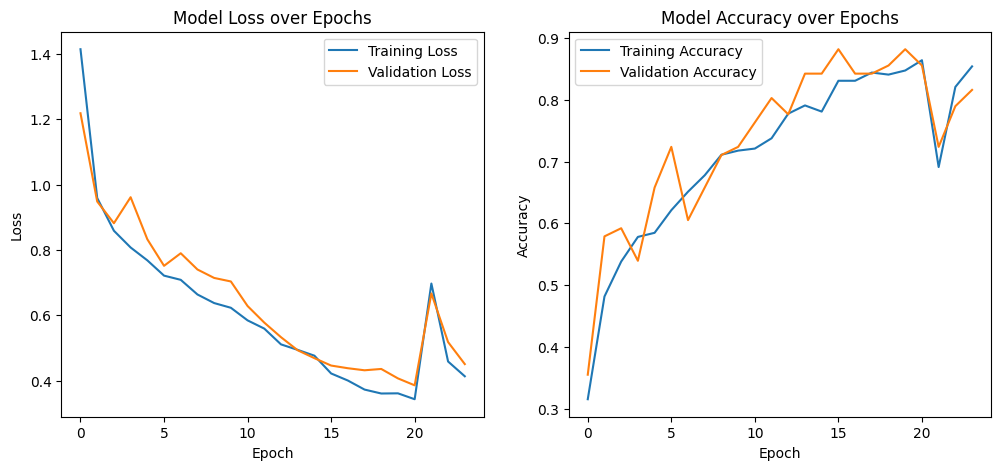

In [77]:
# Training loss and accuracy history
train_loss2 = history2.history['loss']
train_acc2 = history2.history['accuracy']

# Validation loss and accuracy history
val_loss2 = history2.history['val_loss']
val_acc2 = history2.history['val_accuracy']

# Loss curve
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss2, label = 'Training Loss')
plt.plot(val_loss2, label = 'Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_acc2, label = 'Training Accuracy')
plt.plot(val_acc2, label = 'Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

####7.4.1.2 Test Classification Results

In [78]:
loss2, acc2 = model.evaluate([X_img_test2, X_mask_test2, X_meta_test2], y_test2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 990ms/step - accuracy: 0.8482 - loss: 0.3851


In [79]:
print(f"CNN Test Accuracy After Consolidation: {acc2:.4f}")
print(f"CNN Test Loss After Consolidation: {loss2:.4f}")

CNN Test Accuracy After Consolidation: 0.8526
CNN Test Loss After Consolidation: 0.3606


The CNN model had predicted 85.26% accuracy and a loss score of 0.36 on the test data.

In [80]:
y_pred2 = model.predict([X_img_test2, X_mask_test2, X_meta_test2])
y_pred_classes2 = y_pred2.argmax(axis = 1)

print(classification_report(y_test2, y_pred_classes2))
print(confusion_matrix(y_test2, y_pred_classes2))

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 999ms/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        34
           1       0.33      0.25      0.29         4
           2       0.82      0.98      0.90        57

    accuracy                           0.85        95
   macro avg       0.72      0.65      0.67        95
weighted avg       0.87      0.85      0.85        95

[[24  1  9]
 [ 0  1  3]
 [ 0  1 56]]


### 7.4.2 Transfer Learning Performance Metrics

####7.4.2.1 Training Loss and Accuracy

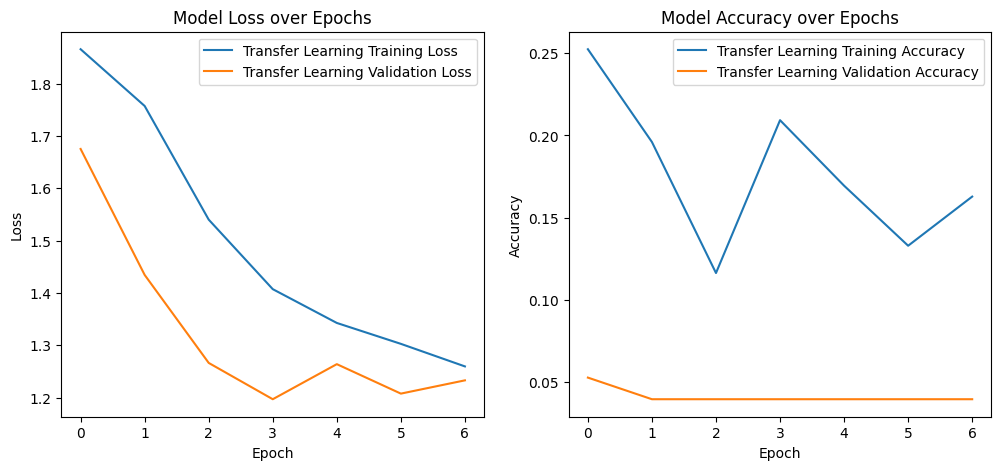

In [81]:
# Training loss and accuracy history
tl_train_loss2 = tl_history2.history['loss']
tl_train_acc2 = tl_history2.history['accuracy']

# Validation loss and accuracy history
tl_val_loss2 = tl_history2.history['val_loss']
tl_val_acc2 = tl_history2.history['val_accuracy']

# Loss curve
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(tl_train_loss2, label = 'Transfer Learning Training Loss')
plt.plot(tl_val_loss2, label = 'Transfer Learning Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(tl_train_acc2, label = 'Transfer Learning Training Accuracy')
plt.plot(tl_val_acc2, label = 'Transfer Learning Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

####7.4.2.2 Test Classification Results

In [82]:
tl_loss2, tl_acc2 = tl_model.evaluate([X_img_test2, X_mask_test2, X_meta_test2], y_test2)

3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.0328 - loss: 1.2030


In [83]:
print(f"TL Test Accuracy After Consolidation: {tl_acc2:.4f}")
print(f"TL Test Loss After Consolidation: {tl_loss2:.4f}")

TL Test Accuracy After Consolidation: 0.0421
TL Test Loss After Consolidation: 1.1993


The transfer learning model had predicted 4.21% accuracy and a loss score of 1.20 on the test data.

In [84]:
tl_y_pred2 = tl_model.predict([X_img_test2, X_mask_test2, X_meta_test2])
tl_y_pred_classes2 = tl_y_pred2.argmax(axis = 1)

print(classification_report(y_test2, tl_y_pred_classes2))
print(confusion_matrix(y_test2, tl_y_pred_classes2))

3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.04      1.00      0.08         4
           2       0.00      0.00      0.00        57

    accuracy                           0.04        95
   macro avg       0.01      0.33      0.03        95
weighted avg       0.00      0.04      0.00        95

[[ 0 34  0]
 [ 0  4  0]
 [ 0 57  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 8.0 Conclusion

At first, when we ran the CNN model on all seven TI-RADS categories, it performed moderately well. The test accuracy was 60% and the macro F1-score was 0.57 indicating performance was uneven across classes. Looking at the confusion matrix, the model correctly classified common categories like TI-RADS 1 (24 out of 26) and TI-RADS 4c (9 out of 13), but it struggled with less frequent or visually similar categories such as TI-RADS 3 (2 out of 4), 4a (6 out of 19), and 4b (7 out of 16). This shows that the CNN could pick up clear features for some nodules, but mid-range scores were harder to distinguish most likely because they look similar on ultrasound.


In contrast, the transfer learning model using a pretrained EfficientNet architecture did not perform as well. Its test accuracy was 19% and the macro F1-score was only 0.05. From the confusion matrix, it mostly predicted TI-RADS 4a (18 out of 19 correct), and failed to generalize to other categories. This suggests that the features learned from natural images didn’t transfer well to thyroid ultrasounds and was probably hampered by the base model's frozen weights.


After consolidating the TI-RADS labels into three broader, clinically meaningful categories (benign, low-risk, and high-risk), the CNN’s performance improved substantially. Test accuracy went up to 85% and the macro F1-score to 0.67. Recall for each group was 0.71 for benign, 0.25 for low-risk, and 0.98 for high-risk, which matches the confusion matrix counts of 24/34, 1/4, and 56/57 correctly classified. The macro recall of 0.65 and F1-score of 0.67 show that performance is fairly balanced even with uneven class sizes, while the weighted F1-score of 0.85 confirms that overall, predictions align well with true labels.


The transfer learning model, on the other hand, performed worse than before consolidation, reaching 4% test accuracy and a macro F1-score of 0.03. It still struggled to identify benign and high-risk nodules, predicting mostly low-risk nodules (4 out of 4 correct) and missing all of the others; over-classifying nodules as low-risk. The macro recall of 0.33 and F1 of 0.03 show that it’s missing a lot of the subtlety in distinguishing between benign and high-risk nodules. This suggests that pretrained models like EfficientNet may not be ideal for specialized medical imaging, especially when their pretrained weights are frozen limiting their adaptability and the features learned from natural images do not transfer well to the subtle patterns in ultrasound scans.


Overall, simplifying the labels into clinically meaningful groups benefited the CNN model the most. It learned to focus on features that distinguish benign, low-risk, and high-risk nodules, which makes it more reliable for identifying the cases that matter most. In a medical context where missing a suspicious case is more costly than a false alarm, the CNN’s recall-driven improvement after consolidation is a promising result. However, the transfer learning architecture can be better improved by using pretrained weights from RadImageNet which is trained on 1.35 million radiological images. We decided against using RadImageNet because the download file for the weights was pretty large and cannot be called on in python and has to be sourced on a local machine or in the cloud.

